In [26]:
import datetime
import os
import json
import re
from functools import partial
from itertools import count, filterfalse

import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from gensim.models import word2vec
from sklearn.mixture import GaussianMixture
from sklearn.feature_extraction.text import TfidfVectorizer

Duplicate key in file '/home/ubuntu/.config/matplotlib/matplotlibrc' line #2.
Duplicate key in file '/home/ubuntu/.config/matplotlib/matplotlibrc' line #3.


In [4]:
# logger
def initialize_logger(dirpath='./output/pipeline'):
    dirname = datetime.datetime.utcnow().strftime('%Y%m%dT%H%M%SZ')
    os.makedirs(os.path.join(dirpath, dirname), exist_ok=True)
    
    def logger(filename, obj):    
        filepath = os.path.join(dirpath, dirname, filename)
        _, ext = os.path.splitext(filename)
        if ext == '.npy':
            np.save(filepath, obj)
        elif ext == '.json':
            json.dump(obj, open(filepath, 'w'), indent=4, ensure_ascii=False)
        else :
            raise Exception

    return logger

In [5]:
# loader
def load_log(timestamp, filename, dirpath='./output/pipeline'):
    filepath = os.path.join(dirpath, timestamp, filename)
    
    _, ext = os.path.splitext(filename)
    if ext == '.npy':
        return np.load(filepath)
    elif ext == '.json':
        return json.load(open(filepath, 'r'))
    else :
        raise Exception

In [6]:
# tokenizer
# TODO: take into account preprocessing adn Japanese
# code i wrote
# def tokenize_document(doc: str) -> [str]:
#     doc = doc.lower().replace('\t','').replace('\n','')
#     doc = re.sub(re.compile(r'[!-\/:-@[-`{-~]'), ' ', doc).split(' ')
#     doc = [token for token in doc if len(token)>2]
#     return [token for token in doc if token not in stop_words]

stopwords = json.load(open('./Archive/stopwords.json'))

def tokernizer(document, stopwords):
    remove = dict.fromkeys(stopwords, True).get
    raw_tokens = re.sub(r'\W+', ' ', document.lower()).split(' ')
    return list(filter(lambda token: len(token) > 1, filterfalse(remove, raw_tokens)))

def tokenize_corpus(corpus: [str]) -> [[str]]: 
    corpus_tokenized = list(map(partial(tokernizer, stopwords=stopwords), corpus))
    assert min(map(len, corpus_tokenized)) > 0
    return corpus_tokenized

In [7]:
# get word vectors by gensim
def build_word_embedding_vectors(corpus_tokenized, word2vec_parameters):
    model = word2vec.Word2Vec(corpus_tokenized, **word2vec_parameters)
    return model.wv.vectors, model.wv.index2word

In [8]:
# culster word vectors by GMM
def culster_embedding_vectors(word_embeddings, gmm_parameters) -> np.ndarray:
    X = word_embeddings
    gm = GaussianMixture(**gmm_parameters)
    gm.fit(X)
    return gm.predict_proba(X)

In [9]:
# TF-IDF takes 20 min
from collections import Counter
from itertools import chain, repeat
from operator import countOf


def build_tfidf_selfmade(corpus, vocab):
    countup = lambda doc: list(map(countOf, repeat(doc), vocab))
    tf = np.array(list(map(countup, corpus)))
    idf = np.log(len(corpus) / (tf > 0).sum(axis=0)) + 1
    return tf, idf, tf*idf

In [10]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

def build_tfidf_sklearn(corpus_tokenized, vocab):
    tfv = TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b', strip_accents='unicode', dtype=np.float64)
    tfv.fit(list(map(' '.join, corpus_tokenized)))
    feature_names = tfv.get_feature_names()
    idf = tfv._tfidf.idf_
    print(len(feature_names), len(idf), len(vocab))
    return np.fromiter(map(dict(zip(feature_names, idf)).get, vocab), dtype='f8')    

In [11]:
def build_word_topic_vector(word_embedding_vectors, word_cluster_probabilities, idf_vector):
    wcv = np.einsum('ij,ik->ijk', word_embedding_vectors, word_cluster_probabilities).reshape(word_embedding_vectors.shape[0], -1)
    return np.einsum('i,ij->ij', idf_vector, wcv)

In [12]:
# document vectors
def count(i=0):
    while True:
        yield i
        i+=1

def normalize_document_vectors(dv: np.ndarray) -> np.ndarray:
    dv_sum = np.square(dv).sum(axis=1)
    dv_l2norm = np.sqrt(dv_sum)
    return np.einsum('ij,i->ij', dv, 1.0/dv_l2norm)

def build_document_vectors(vocabulary, corpus_tokenized, word_topic_vectors):
    vocabulary_idx_map = dict(zip(vocabulary, count()))
    
    document_vecotrs = []
    for doc in corpus_tokenized:
        doc_idx = list(filter(lambda idx: idx is not None, map(vocabulary_idx_map.get, doc)))
        document_vecotrs.append(np.einsum('ij->j',word_topic_vectors[doc_idx]))
    
    return normalize_document_vectors(np.array(document_vecotrs))

In [13]:
# SCDV
def make_sparse(document_vectors, param):
    t = 0.5 * (np.abs(np.min(document_vectors, axis=1).mean()) + np.abs(np.max(document_vectors, axis=1).mean()))
    sparsity_threshold = param * t
    mask = np.abs(document_vectors) < sparsity_threshold
    return np.where(mask, 0.0, document_vectors)

### main

In [ ]:
newsgroups_train = fetch_20newsgroups(subset='train')
corpus = newsgroups_train['data']
corpus_tokenized = tokenize_corpus(corpus)

In [ ]:
word2vec_parameters = {
    'size':200,   # Word vector dimensionality
    'min_count':20,    # Minimum word count
    'workers':40,    # Number of threads to run in parallel
    'window':10,    # Context window size
    'sample':1e-3,    # Downsample setting for frequent words
    'hs':0,
    'sg':1,
    'negative':10,
    'iter':25,
    'seed':1
}

word_embedding_vectors, vocabulary = build_word_embedding_vectors(corpus_tokenized, word2vec_parameters)

In [ ]:
gmm_parameters = {
    'n_components':60,
    'random_state':42,
    'covariance_type':'tied',
    'init_params':'kmeans',
    'max_iter':50
}

word_cluster_probability_matrix = culster_embedding_vectors(word_embedding_vectors, gmm_parameters)

In [ ]:
logger = initialize_logger()
logger('word_cluster_probabilities.npy', word_cluster_probability_matrix)

In [ ]:
word_cluster_probability_matrix.shape

In [ ]:
word_embedding_vectors.shape

In [ ]:
idf_vector = build_tfidf_sklearn(corpus_tokenized, vocabulary)

In [ ]:
word_topic_vectors = build_word_topic_vector(word_embedding_vectors, word_cluster_probability_matrix, idf_vector)

In [ ]:
document_vectors = build_document_vectors(vocabulary, corpus_tokenized, word_topic_vectors)

In [ ]:
document_vectorst_vectors.shape

In [ ]:
logger('word_topic_vectors.npy', word_topic_vectors)

In [ ]:
document_vectors = build_document_vectors(vocabulary, corpus_tokenized, word_topic_vectors)

In [ ]:
logger('document_vectors.npy', document_vectors)

In [ ]:
document_vectors.shape

In [ ]:
param = 0.04
scdv = make_sparse(document_vectors, param)

In [ ]:
logger = initialize_logger()
logger('scdv.npy', scdv)

In [ ]:
scdv.shape

### load

In [ ]:
document_vectors = load_log('20200126T082742Z','document_vectors.npy')

In [ ]:
document_vectors.shape

### classification

In [ ]:
newsgroups_train = fetch_20newsgroups(subset='train')
corpus = newsgroups_train['data']

In [ ]:
X = scdv
y = newsgroups_train['target']
X.shape, y.shape

In [ ]:
def kfold_splitter(n_samples, n_folds, rng):
    shuffled_fold_indices = rng.permutation(np.arange(n_samples) % n_folds)
    for k in range(n_folds):
        mask = shuffled_fold_indices == k
        yield tuple(map(np.flatnonzero, (mask, ~mask)))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

clf = RandomForestClassifier(random_state=0, max_depth=None, max_features='sqrt',
                             class_weight='balanced', n_jobs=-1)

In [ ]:
n_fold = 5
n_samples = y.size
rng = np.random.RandomState(42)

accuracy_train = []
accuracy_test = []

for test_idx, train_idx in kfold_splitter(n_samples, n_fold, rng):
    y_test = y[test_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    X_train = X[train_idx]
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_train)
    bas = balanced_accuracy_score(y_train, y_pred)
    accuracy_train.append(bas)
    
    y_pred = clf.predict(X_test)
    bas = balanced_accuracy_score(y_test, y_pred)
    accuracy_test.append(bas)

accuracy_train = np.array(accuracy_train)
accuracy_test = np.array(accuracy_test)

In [ ]:
accuracy_train

In [ ]:
accuracy_test

In [ ]:
np.average(accuracy_test)

## tf-idf

In [ ]:
newsgroups_train = fetch_20newsgroups(subset='train')
corpus = newsgroups_train['data']
y = newsgroups_train['target']

In [ ]:
corpus_tokenized = tokenize_corpus(corpus)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(list(map(' '.join, corpus_tokenized)))

In [ ]:
X.shape, y.shape

In [ ]:
len(vectorizer.get_feature_names())

In [ ]:
from itertools import chain
len(set(chain.from_iterable(corpus_tokenized)))

In [ ]:
len(list(chain.from_iterable(corpus_tokenized)))

### classification

In [ ]:
def kfold_splitter(n_samples, n_folds, rng):
    shuffled_fold_indices = rng.permutation(np.arange(n_samples) % n_folds)
    for k in range(n_folds):
        mask = shuffled_fold_indices == k
        yield tuple(map(np.flatnonzero, (mask, ~mask)))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

clf = RandomForestClassifier(random_state=0, max_depth=None, max_features='sqrt',
                             class_weight='balanced', n_jobs=-1)

In [ ]:
n_fold = 5
n_samples = y.size
rng = np.random.RandomState(42)

accuracy_train = []
accuracy_test = []

for test_idx, train_idx in kfold_splitter(n_samples, n_fold, rng):
    
    y_test = y[test_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    X_train = X[train_idx]
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_train)
    bas = balanced_accuracy_score(y_train, y_pred)
    accuracy_train.append(bas)
    
    y_pred = clf.predict(X_test)
    bas = balanced_accuracy_score(y_test, y_pred)
    accuracy_test.append(bas)

accuracy_train = np.array(accuracy_train)
accuracy_test = np.array(accuracy_test)

In [ ]:
accuracy_train

In [ ]:
accuracy_test

In [ ]:
np.average(accuracy_test)

## Japanese

In [12]:
import MeCab
import pandas as pd
import re
# from mojimoji import han_to_zen, zen_to_han
import numpy as np
from collections import Counter
from functools import partial, reduce
from itertools import chain, count, filterfalse, repeat
from operator import countOf, itemgetter, methodcaller

compose = lambda *funcs: reduce(lambda f, g: lambda *args, **kwargs: f(g(*args, **kwargs)), funcs)
flip = lambda f: lambda *args: f(*args[::-1])
pipe = flip(compose)


# str -> list
split_text_into_lines = methodcaller('splitlines')
# str -> str
convert_text_to_lowercase = methodcaller('lower')
# str -> str
replace_whitespace_with_blank_char = partial(re.sub, "\s", " ")
# str -> str
remove_whitespace = partial(re.sub, "\s", "")
# str -> str
strip_multiple_blank_chars_to_one = partial(re.sub, " +", " ")
# str -> str
strip_consecutive_chars_to_one = lambda char='ー': partial(re.sub, '{}+'.format(char), '{}'.format(char))

# str -> str
def insert_text_between_blank_chars(text, patterns):
    repls = map(" {} ".format, patterns)
    for pattern, repl in zip(patterns, repls):
        text = text.replace(pattern, repl)
    return text

# str -> str
def remove_whitespace_between_japanese_chars(text):
    """
    """
    chars = "[、。〃々〆〇ぁ-んゔゝゞァ-ンヴヵヶ・ーヽヾ一-龥]"
    pattern = "(?<={chars})\s+(?={chars})".format(chars=chars)
    repl = ""
    return re.sub(pattern, repl, text)

# str -> list
parse_tab_separated_text = re.compile("\t").split
noisy_symbols = list('!"#$%&\'()*+,-./:;<=>?@[]^_`{|}¢£¥§¨¬°±´¶×÷‐―‖"†‡‥…‰′″※℃Å←↑→↓⇒⇔∀∂∃∇∈∋−√∝∞∠∧∨∩∪∫∬∴∵∽≒≠≡≦≧≪≫⊂⊃⊆⊇⊥⌒─━│┃┌┏┐┓└┗┘┛├┝┠┣┤┥┨┫┬┯┰┳┴┷┸┻┼┿╂╋■□▲△▼▽◆◇○◎●◯★☆♀♂♪♭♯〈〉《》「」『』【】〒〓〔〕〜゛゜・＼｀￣（）。、”’｀？！')

def maybe_lemmatize(mecab_node):
    for surface, feature in map(re.compile('\t').split, mecab_node.splitlines()[:-1]):
        if len(feature.split(',')) == 7:
            yield surface
        else:
            yield feature.split(',')[6]

def remove_noisy_symbols(raw_tokens):
    remove = dict.fromkeys(noisy_symbols, True).get
    return filterfalse(remove, raw_tokens)

preprocess = pipe(
    str,
#     han_to_zen,
#     partial(zen_to_han, kana=False),
    convert_text_to_lowercase,
    replace_whitespace_with_blank_char,
    remove_whitespace_between_japanese_chars,
    strip_consecutive_chars_to_one(),
    partial(insert_text_between_blank_chars, patterns=noisy_symbols),
    strip_multiple_blank_chars_to_one,
#     partial(re.sub, '\d', '0'),
    MeCab.Tagger().parse,
    maybe_lemmatize,
    remove_noisy_symbols,
    list
)

Duplicate key in file '/home/ubuntu/.config/matplotlib/matplotlibrc' line #2.
Duplicate key in file '/home/ubuntu/.config/matplotlib/matplotlibrc' line #3.


In [13]:
def tokenize_ja(path):
    with open(path) as f:
        lines = f.readlines()
        lines = [preprocess(line) for line in lines] 
        return list(chain.from_iterable(lines))

In [15]:
import glob

categories = ['dokujo-tsushin', 'it-life-hack', 'kaden-channel', 'livedoor-homme', 'movie-enter', 'peachy', 'smax',
            'sports-watch', 'topic-news']

data = pd.DataFrame([(c, tokenize_ja(path)) for c in categories for path in glob.glob(f'./text/{c}/*.txt')],
                            columns=['category', 'text'])

In [ ]:
# check null
data.loc[data.isnull().any(axis=1)]

In [ ]:
corpus_tokenized_ja = data['text'].tolist()

In [ ]:
logger = initialize_logger()
logger('corpus_tokenized_ja.json', corpus_tokenized_ja)

In [ ]:
corpus_tokenized_ja = load_log('20200129T105243Z','corpus_tokenized_ja.json')

In [ ]:
len(corpus_tokenized_ja)

In [ ]:
# overview japanese corpus
import matplotlib.pyplot as plt

len_tokens_ja = list(map(len, corpus_tokenized_ja))
plt.hist(len_tokens_ja, bins=40)
plt.yscale('log')

In [ ]:
len(corpus_tokenized_ja)

In [ ]:
len(list(set(chain.from_iterable(corpus_tokenized_ja))))

### main 

In [ ]:
corpus_tokenized = corpus_tokenized_ja

In [ ]:
word2vec_parameters = {
    'size':200,   # Word vector dimensionality
    'min_count':20,    # Minimum word count
    'workers':40,    # Number of threads to run in parallel
    'window':10,    # Context window size
    'sample':1e-3,    # Downsample setting for frequent words
    'hs':0,
    'sg':1,
    'negative':10,
    'iter':25,
    'seed':1
}

word_embedding_vectors, vocabulary = build_word_embedding_vectors(corpus_tokenized, word2vec_parameters)

# logger = initialize_logger()
logger('word_embedding_vectors.npy', word_embedding_vectors)
logger('vocabulary.json', vocabulary)

In [ ]:
word_embedding_vectors.shape, len(vocabulary)

In [ ]:
vocabulary = word_cluster_probability_matrix = load_log('20200129T105243Z', 'vocabulary.json')

In [ ]:
gmm_parameters = {
    'n_components':80,
    'random_state':42,
    'covariance_type':'tied',
    'init_params':'kmeans',
    'max_iter':50
}

word_cluster_probability_matrix = culster_embedding_vectors(word_embedding_vectors, gmm_parameters)

logger('word_cluster_probabilities.npy', word_cluster_probability_matrix)

In [ ]:
word_cluster_probability_matrix = load_log('20200127T154202Z', 'word_cluster_probabilities.npy')

In [ ]:
word_cluster_probability_matrix.shape

In [ ]:
import matplotlib.pyplot as plt
plt.hist(word_cluster_probability_matrix.ravel(), bins=500, range=(0,1))
plt.yscale('log')
plt.xlim([0,1])

In [ ]:
idf_vector = build_tfidf_sklearn(corpus_tokenized, vocabulary)

In [ ]:
np.isnan(idf_vector).sum()

In [ ]:
np.array(vocabulary)[np.isnan(idf_vector)]

In [ ]:
tf, idf, tfidf = build_tfidf_selfmade(corpus_tokenized, vocabulary)

In [ ]:
np.isnan(idf).sum()

In [ ]:
idf

In [ ]:
idf_vector

In [ ]:
plt.scatter(idf, idf_vector)

In [ ]:
word_topic_vectors = build_word_topic_vector(word_embedding_vectors, word_cluster_probability_matrix, idf)

In [ ]:
word_topic_vectors.shape

In [ ]:
document_vectors = build_document_vectors(vocabulary, corpus_tokenized, word_topic_vectors)

param = 0.04
scdv = make_sparse(document_vectors, param)

logger('scdv.npy', scdv)
scdv.shape

In [23]:
scdv = load_log('20200129T105243Z', 'scdv.npy')

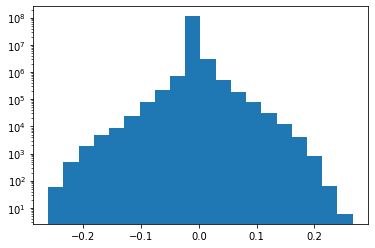

In [25]:
import matplotlib.pyplot as plt

plt.hist(scdv.ravel(), bins=20)
plt.yscale('log')

### classification

In [17]:
data

,category,text
0,dokujo-tsushin,./text/dokujo-tsushin/dokujo-tsushin-5934284.txt
1,dokujo-tsushin,./text/dokujo-tsushin/dokujo-tsushin-4848785.txt
2,dokujo-tsushin,./text/dokujo-tsushin/dokujo-tsushin-5247353.txt
3,dokujo-tsushin,./text/dokujo-tsushin/dokujo-tsushin-5653189.txt
4,dokujo-tsushin,./text/dokujo-tsushin/dokujo-tsushin-6218046.txt
...,...,...
7371,topic-news,./text/topic-news/topic-news-5914835.txt
7372,topic-news,./text/topic-news/topic-news-6403803.txt
7373,topic-news,./text/topic-news/topic-news-6703537.txt
7374,topic-news,./text/topic-news/topic-news-6723717.txt


In [18]:
category = data['category'].tolist()

In [19]:
encoder = dict(zip(np.unique(category),count(1)))

In [20]:
y = np.array(list(map(encoder.get, category)))

In [26]:
X = scdv
X.shape, y.shape

((7376, 16000), (7376,))

In [ ]:
def kfold_splitter(n_samples, n_folds, rng):
    shuffled_fold_indices = rng.permutation(np.arange(n_samples) % n_folds)
    for k in range(n_folds):
        mask = shuffled_fold_indices == k
        yield tuple(map(np.flatnonzero, (mask, ~mask)))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

clf = RandomForestClassifier(random_state=0, max_depth=None, max_features='sqrt',
                             class_weight='balanced', n_jobs=-1)

In [ ]:
n_fold = 5
n_samples = y.size
rng = np.random.RandomState(42)

accuracy_train = []
accuracy_test = []

for test_idx, train_idx in kfold_splitter(n_samples, n_fold, rng):
    y_test = y[test_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    X_train = X[train_idx]
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_train)
    bas = balanced_accuracy_score(y_train, y_pred)
    accuracy_train.append(bas)
    
    y_pred = clf.predict(X_test)
    bas = balanced_accuracy_score(y_test, y_pred)
    accuracy_test.append(bas)

accuracy_train = np.array(accuracy_train)
accuracy_test = np.array(accuracy_test)

In [ ]:
accuracy_train

In [ ]:
accuracy_test

In [ ]:
np.average(accuracy_test)

### tfidf - ja - class

In [27]:
import glob

categories = ['dokujo-tsushin', 'it-life-hack', 'kaden-channel', 'livedoor-homme', 'movie-enter', 'peachy', 'smax',
            'sports-watch', 'topic-news']

data = pd.DataFrame([(c, path) for c in categories for path in glob.glob(f'./text/{c}/*.txt')],
                            columns=['category', 'text'])

In [28]:
category = data['category'].tolist()
encoder = dict(zip(np.unique(category),count(1)))
y = np.array(list(map(encoder.get, category)))

In [14]:
corpus_tokenized_ja = load_log('20200129T105243Z', 'corpus_tokenized_ja.json')

In [15]:
vocabulary = load_log('20200129T105243Z', 'vocabulary.json')

In [16]:
len(vocabulary)

11940

In [17]:
tf, idf, tfidf = build_tfidf_selfmade(corpus_tokenized_ja, vocabulary)

In [20]:
tfidf.shape

(7376, 11940)

In [21]:
X = tfidf

In [29]:
X.shape, y.shape

((7376, 11940), (7376,))

In [30]:
def kfold_splitter(n_samples, n_folds, rng):
    shuffled_fold_indices = rng.permutation(np.arange(n_samples) % n_folds)
    for k in range(n_folds):
        mask = shuffled_fold_indices == k
        yield tuple(map(np.flatnonzero, (mask, ~mask)))

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

clf = RandomForestClassifier(random_state=0, max_depth=None, max_features='sqrt',
                             class_weight='balanced', n_jobs=-1)

In [32]:
n_fold = 5
n_samples = y.size
rng = np.random.RandomState(42)

accuracy_train = []
accuracy_test = []

for test_idx, train_idx in kfold_splitter(n_samples, n_fold, rng):
    y_test = y[test_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    X_train = X[train_idx]
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_train)
    bas = balanced_accuracy_score(y_train, y_pred)
    accuracy_train.append(bas)
    
    y_pred = clf.predict(X_test)
    bas = balanced_accuracy_score(y_test, y_pred)
    accuracy_test.append(bas)

accuracy_train = np.array(accuracy_train)
accuracy_test = np.array(accuracy_test)

In [33]:
accuracy_train

array([1., 1., 1., 1., 1.])

In [34]:
accuracy_test

array([0.91243121, 0.91286318, 0.9024295 , 0.91307296, 0.91009114])

In [35]:
np.average(accuracy_test)

0.910177598335179

## workspace 

In [ ]:
def add_1(x):
    return x + 1
def add_2(x):
    return x + 2

In [ ]:
from operator import itemgetter
reverse = itemgetter(slice(None, None, -1))

In [ ]:
from functools import reduce
def flip(f):
    return lambda *args: f(*reverse(args))
def compose(*fs):
    return reduce(lambda f, g: lambda *args, **kwargs: f(g(*args, **kwargs)), fs)
pipe = flip(compose)

In [ ]:
add3 = pipe(add_1, add_2)

In [ ]:
add3(3)

In [ ]:
add_3(3) # equivalent to `add_2(add_1(3))`

In [ ]:
itemgetter(slice(None, None, -1))

In [ ]:
arr = list([1,3,5,7,9])
arr[::-1]